In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
from sklearn.metrics import mean_absolute_error
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import t
import seaborn as sns
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from mlxtend.evaluate import permutation_test
from tqdm import tqdm
import pickle

# stat functions
def mlxtend_corr(var1, var2):
    p_corr = permutation_test(var1, var2,
                        func=lambda x, y: np.corrcoef(x, y)[0,1],
                        method='approximate',
                        num_rounds=100,
                        seed=42)
    r_corr = np.corrcoef(var1, var2)[0,1]
    return round(p_corr, 4), round(r_corr, 2) 

def smooth_array(array, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be positive.")
    return np.convolve(array, np.ones(window_size) / window_size, mode='same')
import seaborn as sns

def r2t(r, n):
        return (r * np.sqrt(n - 2)) / np.sqrt(1 - r ** 2)
def p_rep(t_stat, df):
    return t.cdf(np.abs(t_stat) / np.sqrt(2), df)
def ps_rep(t_stat, df, alpha):
    term1 = np.abs(t_stat) / np.sqrt(2)
    #term2 = t.ppf(1 - alpha / 2, df) / np.sqrt(2)
    term2 = t.ppf(1 - alpha, df) / np.sqrt(2) # one tailed
    return t.cdf(term1 - term2, df)
def r2psrep(r, n, alpha):
    return ps_rep(r2t(r, n), n - 2, alpha)

#### phenotypes

In [2]:
dataIn = ''
dataOut = ''

# Phenotypes
alertness = ['MMSE_Score','PSQI_Score']
cognition = ['PicSeq_AgeAdj','CardSort_AgeAdj','Flanker_AgeAdj','PMAT24_A_CR','CogFluidComp_AgeAdj','CogCrystalComp_AgeAdj',
'CogEarlyComp_AgeAdj','CogTotalComp_AgeAdj','ReadEng_AgeAdj','PicVocab_AgeAdj','ProcSpeed_AgeAdj','DDisc_AUC_200','VSPLOT_TC','SCPT_SEN','SCPT_SPEC']
memory = ['IWRD_TOT','ListSort_AgeAdj']
emotion = ['ER40ANG','ER40FEAR','ER40HAP','ER40NOE','ER40SAD','AngAffect_Unadj','AngHostil_Unadj','AngAggr_Unadj','FearAffect_Unadj',
'FearSomat_Unadj','Sadness_Unadj','LifeSatisf_Unadj','MeanPurp_Unadj','PosAffect_Unadj','Friendship_Unadj','Loneliness_Unadj',
'PercHostil_Unadj','PercReject_Unadj','EmotSupp_Unadj','InstruSupp_Unadj','PercStress_Unadj','SelfEff_Unadj']
motor = ['Endurance_AgeAdj', 'GaitSpeed_Comp', 'Dexterity_AgeAdj', 'Strength_AgeAdj']
personality = ['NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E']
sensory = ['Noise_Comp','Odor_AgeAdj','PainIntens_RawScore','PainInterf_Tscore','Taste_AgeAdj','Mars_Final']
phenotype_names =['age_num','Gender'] + alertness + cognition + memory + emotion + motor + personality + sensory

#### replication function

In [3]:
ALPHA = 0.05
def replicability(phen, conn):
    pdis = np.zeros((17, 100))
    prep = np.zeros((17, 100))
    rdis = np.zeros((17, 100))
    rrep = np.zeros((17, 100))

    for perm_row, sampleSize in enumerate(np.arange(25,450, 25)):
        for perm_col in range(100):
        
            ydis = np.load(f'{dataOut}/phenotype-{phen}_conntype-{conn}_data-ydiscovery_sample-{sampleSize}.npy')
            yhatdis = np.load(f'{dataOut}/phenotype-{phen}_conntype-{conn}_data-yhatdiscovery_sample-{sampleSize}.npy')
            yrep = np.load(f'{dataOut}/phenotype-{phen}_conntype-{conn}_data-yreplication_sample-{sampleSize}.npy')
            yhatrep = np.load(f'{dataOut}/phenotype-{phen}_conntype-{conn}_data-yhatreplication_sample-{sampleSize}.npy')
            
            pdis[perm_row, perm_col] = mlxtend_corr(ydis[:,perm_col], yhatdis[:,perm_col])[0]
            prep[perm_row, perm_col] = mlxtend_corr(yrep[:,perm_col], yhatrep[:,perm_col])[0]
            
            rdis[perm_row, perm_col] = mlxtend_corr(ydis[:,perm_col], yhatdis[:,perm_col])[1]
            rrep[perm_row, perm_col] = mlxtend_corr(yrep[:,perm_col], yhatrep[:,perm_col])[1]            
            
    counts = np.zeros(17)
    effect_sizes = np.zeros((17,2))
    for i in range(17):
        valid_indices = (pdis[i] < ALPHA) & (rdis[i] > 0.0)
        counts[i] = np.sum((prep[i][valid_indices] < ALPHA) &  (rrep[i][valid_indices] > 0.0) )/np.sum(valid_indices)
        effect_sizes[i,0] = rdis[i][valid_indices].mean()
        effect_sizes[i,1] = rrep[i][valid_indices].mean()
    return counts, effect_sizes[:,0], effect_sizes[:,1], rdis, rrep

#### trait-like and state-like classification

In [4]:
alertness_c = ['State-like']*len(alertness)
cognition_c = ['Trait-like']*len(cognition)
memory_c = ['State-like']*len(memory)
emotion_c = ['State-like']*len(emotion)
motor_c = ['Trait-like']*len(motor)
personality_c = ['Trait-like']*len(personality)
sensory_c = ['Trait-like']*len(sensory)
phenotype_names_c =['Trait-like','Trait-like'] + alertness_c + cognition_c + memory_c + emotion_c + motor_c + personality_c + sensory_c
category = pd.DataFrame(phenotype_names_c)
category.columns = ['State-/Trait-like']
category.index = phenotype_names

# replicability_results = []
# for conn in tqdm(range(5)):
#     results = Parallel(n_jobs=-1)(
#         delayed(replicability)(phen, conn)
#         for phen in phenotype_names
#     )
#     replicability_results.append(results)

#### load precomputed data - available upon reasonable request

In [5]:
with open('../main_stores/replicability_results_SVR.pkl', 'rb') as file:
  replicability_results = pickle.load(file)

#### effect sizes across DWI connectome types

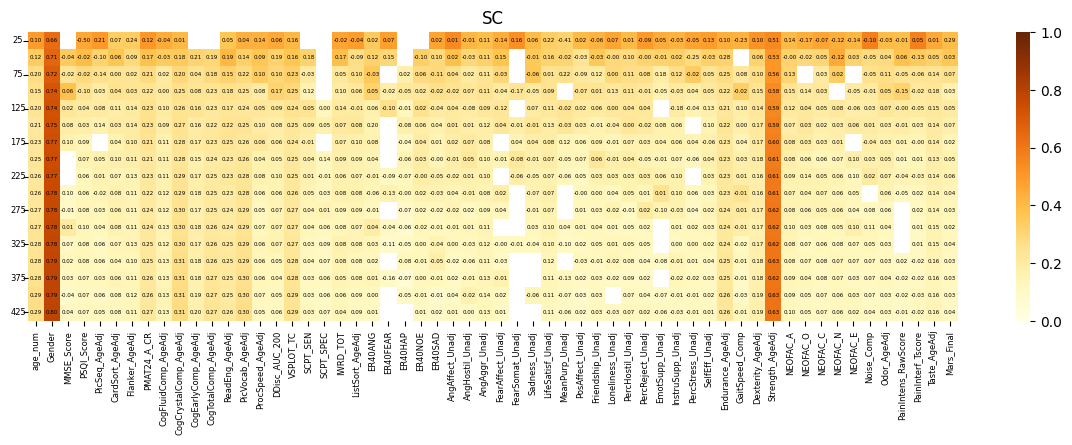

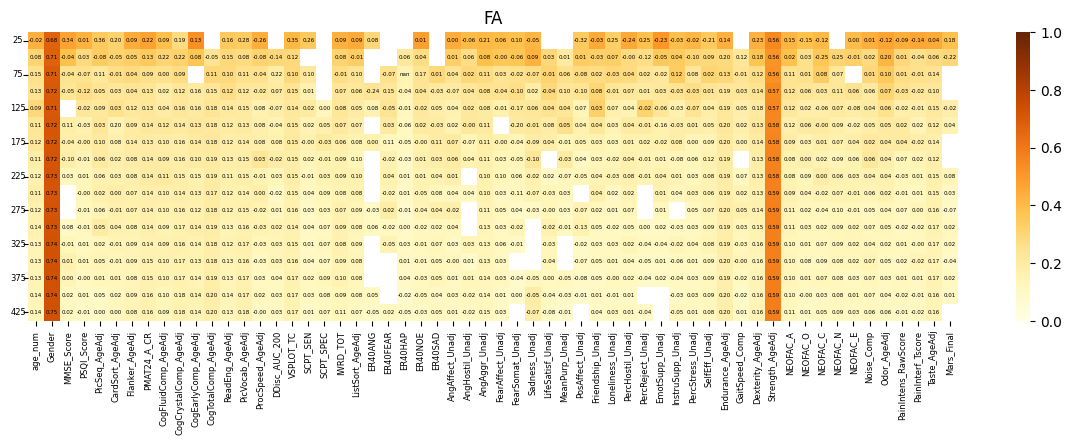

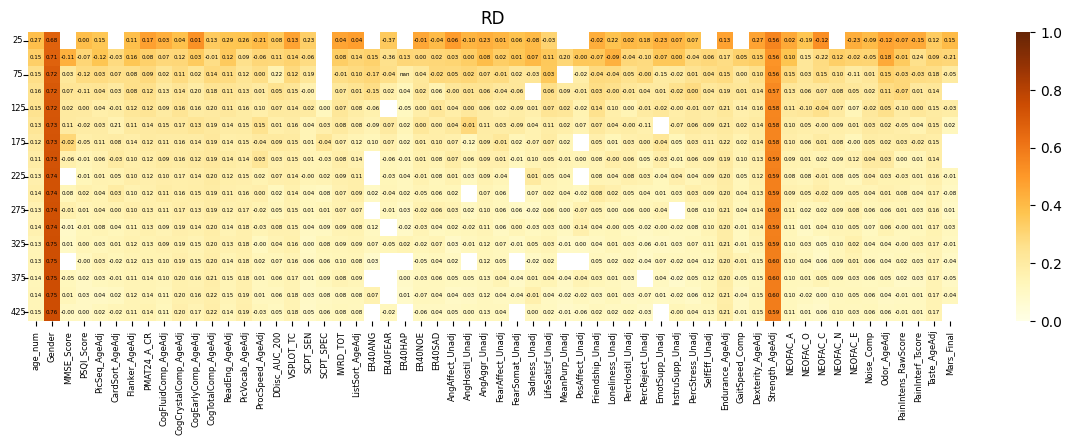

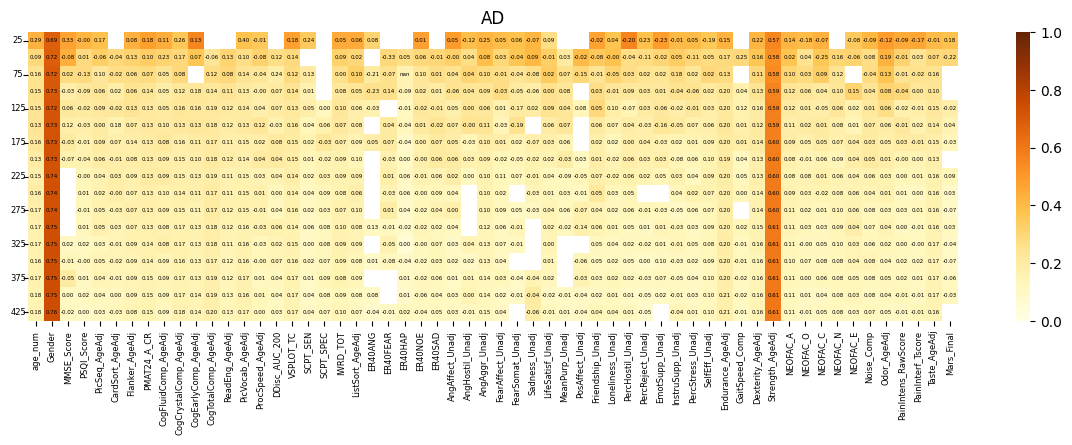

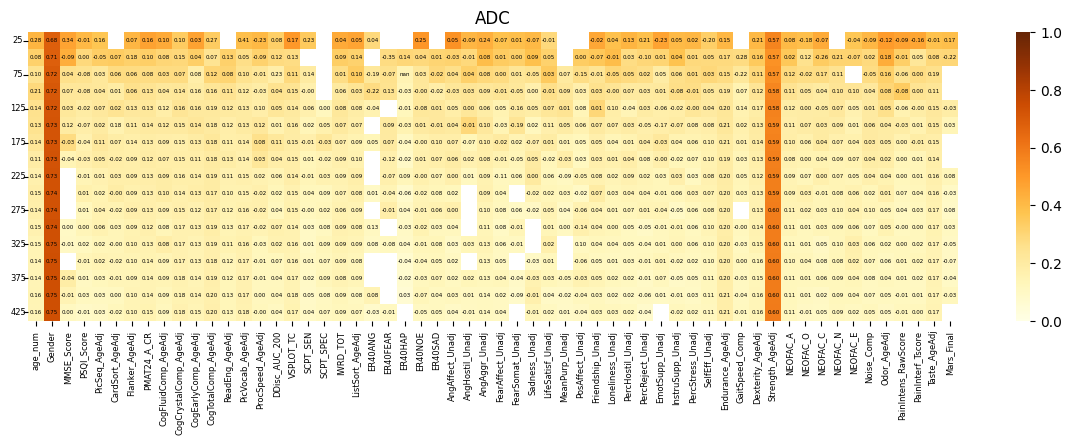

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
list_methods = ['SC', 'FA', 'RD', 'AD', 'ADC']
colormaps = ['Oranges']
for enu, method in enumerate(list_methods):
    tempAll_color = []
    tempAll_annotation = []
    for i in range(len(phenotype_names)):
        tempAll_color.append(replicability_results[enu][i][1])
        tempAll_annotation.append(replicability_results[enu][i][2])
    data_for_coloring = np.stack(tempAll_color).T
    data_for_annotation = np.stack(tempAll_annotation).T
    fig, ax = plt.subplots(figsize=(5*3,1.25*3), dpi=100)
    sns.heatmap(data_for_coloring,annot=data_for_annotation,fmt=".2f",cmap='YlOrBr',cbar=True,vmin=0,vmax=1,annot_kws={"fontsize": 4, "color": "black"})
    ax.set_yticks(np.arange(0.5, 17.5, 2))
    sample_size_labels = np.arange(25, 450, 50)
    ax.set_yticklabels(sample_size_labels, rotation=0, fontsize=6, ha='center')
    ax.set_xticks(np.arange(0.5, 58.5, 1))
    ax.set_xticklabels(phenotype_names, rotation=90, fontsize=6)
    ax.set_title(list_methods[enu])
    

In [7]:
all_counts = []
all_effect_sizes_dis_mean = []
all_effect_sizes_rep_mean = []
all_rdis = []
all_rrep = []

for i in range(5):
    counts, effect_sizes_dis_mean, effect_sizes_rep_mean, rdis, rrep = zip(*replicability_results[i])
    all_counts.append(counts)
    all_effect_sizes_dis_mean.append(effect_sizes_dis_mean)
    all_effect_sizes_rep_mean.append(effect_sizes_rep_mean)
    all_rdis.append(rdis)
    all_rrep.append(rrep)
allCounts = pd.DataFrame(all_counts)
all_rdis = np.array(all_rdis)
all_rrep = np.array(all_rrep)
all_rrep.shape

(5, 58, 17, 100)

In [8]:
finalResults = []
for conntype in range(5):
    model_history = np.zeros((58, 3))
    for phenIdx in range(58):
        temp_phen_replicability = np.array(allCounts.iloc[conntype, phenIdx]) #replicability_results[conntype][phenIdx][0]
        start_index = next((i for i, value in enumerate(temp_phen_replicability) if value > 0.8), None)  # correct the code
        #if np.mean(temp_phen_replicability[start_index:]) > 0.8:
        if start_index is not None and np.mean(temp_phen_replicability[start_index:]) > 0.8:
            out_sample_size = np.arange(25, 450, 25)[start_index]
            out_dis_effect_size = replicability_results[conntype][phenIdx][1][start_index]
            out_rep_effect_size = replicability_results[conntype][phenIdx][2][start_index]
        else:
            out_sample_size = np.inf
            out_dis_effect_size = np.inf
            out_rep_effect_size = np.inf
        model_history[phenIdx, 0] = out_sample_size
        model_history[phenIdx, 1] = out_dis_effect_size
        model_history[phenIdx, 2] = out_rep_effect_size
    finalResults.append(model_history)

In [9]:
alertness_phen = ['alertness']*len(alertness)
cognition_phen = ['cognition']*len(cognition)
memory_phen = ['memory']*len(memory)
emotion_phen = ['emotion']*len(emotion)
motor_phen = ['motor']*len(motor)
personality_phen = ['personality']*len(personality)
sensory_phen = ['sensory']*len(sensory)
phenotype_names_phen =['demography','demography'] + alertness_phen + cognition_phen + memory_phen + emotion_phen + motor_phen+ personality_phen + sensory_phen

#### main results dataframe

In [10]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message="DataFrame.applymap has been deprecated")
combined = pd.concat([pd.DataFrame(finalResults[0]), pd.DataFrame(finalResults[1]), pd.DataFrame(finalResults[2]), pd.DataFrame(finalResults[3]), pd.DataFrame(finalResults[4])], axis=1) 
combined.columns = [
    'sample_size_streamlines', 'effect_size_dis_streamlines', 'effect_size_rep_streamlines',
                    'sample_size_fa', 'effect_size_dis_fa', 'effect_size_rep_fa',
                    'sample_size_rd', 'effect_size_dis_rd', 'effect_size_rep_rd',
                    'sample_size_ad', 'effect_size_dis_ad', 'effect_size_rep_ad',
                    'sample_size_adc', 'effect_size_dis_adc', 'effect_size_rep_adc'
                    ]
combined.index = phenotype_names
combined['category'] = phenotype_names_c
combined['score'] = phenotype_names_phen

combined_zero = combined.iloc[:,0:15].applymap(lambda x: 0 if np.isinf(x) else x)
combined['overall_rep'] = (combined_zero.sum(axis=1)>0).astype(int)
combined['overall_rep'].sum()
selected_columns = combined.filter(like='sample_size_', axis=1)
combined['minimum_sample'] = combined[selected_columns.columns].min(axis=1)
combined['min_sample_method'] = combined.apply(lambda row: row[selected_columns.columns].idxmin(), axis=1)
combined

,sample_size_streamlines,effect_size_dis_streamlines,effect_size_rep_streamlines,sample_size_fa,effect_size_dis_fa,effect_size_rep_fa,sample_size_rd,effect_size_dis_rd,effect_size_rep_rd,sample_size_ad,effect_size_dis_ad,effect_size_rep_ad,sample_size_adc,effect_size_dis_adc,effect_size_rep_adc,category,score,overall_rep,minimum_sample,min_sample_method
age_num,150.0,0.215333,0.208444,350.0,0.144000,0.128286,325.0,0.142162,0.132432,250.0,0.191111,0.163611,300.0,0.163333,0.147500,Trait-like,demography,1,150.0,sample_size_streamlines
Gender,25.0,0.638161,0.656897,25.0,0.675109,0.681739,25.0,0.673297,0.677253,25.0,0.683261,0.688261,25.0,0.680326,0.683261,Trait-like,demography,1,25.0,sample_size_streamlines
MMSE_Score,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,State-like,alertness,0,inf,sample_size_streamlines
PSQI_Score,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,State-like,alertness,0,inf,sample_size_streamlines
PicSeq_AgeAdj,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,Trait-like,cognition,0,inf,sample_size_streamlines
CardSort_AgeAdj,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,Trait-like,cognition,0,inf,sample_size_streamlines
Flanker_AgeAdj,400.0,0.130303,0.116667,inf,inf,inf,400.0,0.140714,0.118810,inf,inf,inf,inf,inf,inf,Trait-like,cognition,1,400.0,sample_size_streamlines
PMAT24_A_CR,125.0,0.256410,0.228974,300.0,0.174677,0.136452,350.0,0.155000,0.133871,350.0,0.156667,0.137879,350.0,0.154375,0.136250,Trait-like,cognition,1,125.0,sample_size_streamlines
CogFluidComp_AgeAdj,350.0,0.150541,0.128378,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,Trait-like,cognition,1,350.0,sample_size_streamlines
CogCrystalComp_AgeAdj,100.0,0.261000,0.252000,225.0,0.181163,0.151628,225.0,0.177500,0.170625,275.0,0.168511,0.151064,225.0,0.178684,0.156579,Trait-like,cognition,1,100.0,sample_size_streamlines


#### overall replicability

In [11]:
rep = np.zeros((5,1))
for conntype in np.arange(0,5,1):
   df = pd.DataFrame(finalResults[conntype])
   c = ((df.iloc[:, 0] > 0) & (df.iloc[:, 0] < 450)).sum()
   rep[conntype,0] = round((c/58 * 100),0)
   print(f'replication of {list_methods[conntype]}: {rep[conntype,0]}%')

replication of SC: 28.0%
replication of FA: 24.0%
replication of RD: 28.0%
replication of AD: 24.0%
replication of ADC: 24.0%


In [12]:
print('*******  58 total   *********')
print ('combined: ', combined['overall_rep'].sum()) 
print ('trait-like: ', combined[combined['category'] == 'Trait-like']['overall_rep'].sum()) 
print ('state-like: ', combined[combined['category'] == 'State-like']['overall_rep'].sum()) 
print('****************')
print ('SC: ', (combined['sample_size_streamlines']<450).sum())
print ('trait-like: ', (combined[combined['category'] =='Trait-like']['sample_size_streamlines']<450).sum()) 
print ('state-like: ', (combined[combined['category'] =='State-like']['sample_size_streamlines']<450).sum()) 
print('****************')
print ('FA: ', (combined['sample_size_fa']<450).sum())
print ('trait-like: ', (combined[combined['category'] =='Trait-like']['sample_size_fa']<450).sum()) 
print ('state-like: ', (combined[combined['category'] =='State-like']['sample_size_fa']<450).sum()) 
print('****************')
print ('RD: ', (combined['sample_size_rd']<450).sum())
print ('trait-like: ', (combined[combined['category'] =='Trait-like']['sample_size_rd']<450).sum()) 
print ('state-like: ', (combined[combined['category'] =='State-like']['sample_size_rd']<450).sum()) 
print('****************')
print ('AD: ', (combined['sample_size_ad']<450).sum())
print ('trait-like: ', (combined[combined['category'] =='Trait-like']['sample_size_ad']<450).sum()) 
print ('state-like: ', (combined[combined['category'] =='State-like']['sample_size_ad']<450).sum()) 
print('****************')
print ('ADC: ', (combined['sample_size_adc']<450).sum())
print ('trait-like: ', (combined[combined['category'] =='Trait-like']['sample_size_adc']<450).sum()) 
print ('state-like: ', (combined[combined['category'] =='State-like']['sample_size_adc']<450).sum()) 


*******  58 total   *********
combined:  18
trait-like:  16
state-like:  2
****************
SC:  16
trait-like:  15
state-like:  1
****************
FA:  14
trait-like:  13
state-like:  1
****************
RD:  16
trait-like:  14
state-like:  2
****************
AD:  14
trait-like:  13
state-like:  1
****************
ADC:  14
trait-like:  12
state-like:  2


In [13]:
agg_funcs = ['mean', 'median', 'min', 'max']

stats_part1 = combined[~np.isinf(combined['sample_size_streamlines'])].iloc[:,0:3].agg(agg_funcs).round(2)
stats_part2 = combined[~np.isinf(combined['sample_size_fa'])].iloc[:,3:6].agg(agg_funcs).round(2)
stats_part3 = combined[~np.isinf(combined['sample_size_rd'])].iloc[:,6:9].agg(agg_funcs).round(2)
stats_part4 = combined[~np.isinf(combined['sample_size_ad'])].iloc[:,9:12].agg(agg_funcs).round(2)
stats_part5 = combined[~np.isinf(combined['sample_size_adc'])].iloc[:,12:15].agg(agg_funcs).round(2)

combined_stats_df = pd.concat([stats_part1, stats_part2, stats_part3, stats_part4, stats_part5], axis=1)
combined_stats_df

,sample_size_streamlines,effect_size_dis_streamlines,effect_size_rep_streamlines,sample_size_fa,effect_size_dis_fa,effect_size_rep_fa,sample_size_rd,effect_size_dis_rd,effect_size_rep_rd,sample_size_ad,effect_size_dis_ad,effect_size_rep_ad,sample_size_adc,effect_size_dis_adc,effect_size_rep_adc
mean,187.5,0.25,0.24,237.5,0.23,0.22,260.94,0.22,0.21,251.79,0.23,0.22,251.79,0.23,0.22
median,150.0,0.22,0.22,275.0,0.17,0.15,275.00,0.16,0.15,275.00,0.17,0.15,275.00,0.16,0.15
min,25.0,0.13,0.12,25.0,0.14,0.13,25.00,0.12,0.12,25.00,0.13,0.11,25.00,0.12,0.11
max,400.0,0.64,0.66,350.0,0.68,0.68,400.00,0.67,0.68,400.00,0.68,0.69,425.00,0.68,0.68


In [14]:
warnings.filterwarnings('ignore', category=UserWarning, message="Boolean Series key will be reindexed to match DataFrame index.")

agg_funcs = ['mean', 'median', 'min', 'max']

stats_part1 = combined[combined['category'] == 'Trait-like'][~np.isinf(combined['sample_size_streamlines'])].iloc[:,0:3].agg(agg_funcs).round(2)
stats_part2 = combined[combined['category'] == 'Trait-like'][~np.isinf(combined['sample_size_fa'])].iloc[:,3:6].agg(agg_funcs).round(2)
stats_part3 = combined[combined['category'] == 'Trait-like'][~np.isinf(combined['sample_size_rd'])].iloc[:,6:9].agg(agg_funcs).round(2)
stats_part4 = combined[combined['category'] == 'Trait-like'][~np.isinf(combined['sample_size_ad'])].iloc[:,9:12].agg(agg_funcs).round(2)
stats_part5 = combined[combined['category'] == 'Trait-like'][~np.isinf(combined['sample_size_adc'])].iloc[:,12:15].agg(agg_funcs).round(2)

combined_stats_df = pd.concat([stats_part1, stats_part2, stats_part3, stats_part4, stats_part5], axis=1)
combined_stats_df

,sample_size_streamlines,effect_size_dis_streamlines,effect_size_rep_streamlines,sample_size_fa,effect_size_dis_fa,effect_size_rep_fa,sample_size_rd,effect_size_dis_rd,effect_size_rep_rd,sample_size_ad,effect_size_dis_ad,effect_size_rep_ad,sample_size_adc,effect_size_dis_adc,effect_size_rep_adc
mean,173.33,0.26,0.25,228.85,0.24,0.23,242.86,0.23,0.22,246.15,0.24,0.22,227.08,0.25,0.23
median,150.00,0.23,0.22,275.00,0.17,0.15,275.00,0.17,0.16,275.00,0.17,0.16,250.00,0.17,0.15
min,25.00,0.13,0.12,25.00,0.14,0.13,25.00,0.14,0.12,25.00,0.13,0.11,25.00,0.14,0.12
max,400.00,0.64,0.66,350.00,0.68,0.68,400.00,0.67,0.68,400.00,0.68,0.69,375.00,0.68,0.68


In [15]:
agg_funcs = ['mean', 'median', 'min', 'max']

stats_part1 = combined[combined['category'] == 'State-like'][~np.isinf(combined['sample_size_streamlines'])].iloc[:,0:3].agg(agg_funcs).round(2)
stats_part2 = combined[combined['category'] == 'State-like'][~np.isinf(combined['sample_size_fa'])].iloc[:,3:6].agg(agg_funcs).round(2)
stats_part3 = combined[combined['category'] == 'State-like'][~np.isinf(combined['sample_size_rd'])].iloc[:,6:9].agg(agg_funcs).round(2)
stats_part4 = combined[combined['category'] == 'State-like'][~np.isinf(combined['sample_size_ad'])].iloc[:,9:12].agg(agg_funcs).round(2)
stats_part5 = combined[combined['category'] == 'State-like'][~np.isinf(combined['sample_size_adc'])].iloc[:,12:15].agg(agg_funcs).round(2)

combined_stats_df = pd.concat([stats_part1, stats_part2, stats_part3, stats_part4, stats_part5], axis=1)
combined_stats_df

,sample_size_streamlines,effect_size_dis_streamlines,effect_size_rep_streamlines,sample_size_fa,effect_size_dis_fa,effect_size_rep_fa,sample_size_rd,effect_size_dis_rd,effect_size_rep_rd,sample_size_ad,effect_size_dis_ad,effect_size_rep_ad,sample_size_adc,effect_size_dis_adc,effect_size_rep_adc
mean,400.0,0.13,0.14,350.0,0.14,0.13,387.5,0.13,0.12,325.0,0.14,0.13,400.0,0.12,0.12
median,400.0,0.13,0.14,350.0,0.14,0.13,387.5,0.13,0.12,325.0,0.14,0.13,400.0,0.12,0.12
min,400.0,0.13,0.14,350.0,0.14,0.13,375.0,0.12,0.12,325.0,0.14,0.13,375.0,0.12,0.11
max,400.0,0.13,0.14,350.0,0.14,0.13,400.0,0.14,0.13,325.0,0.14,0.13,425.0,0.13,0.13


overall replicabilities 

In [16]:
mask = combined['overall_rep'] == 1
indices = combined.index[mask].tolist()
ind = []
for phen in phenotype_names:
    if phen in indices:
        ind.append(1)
    else:
        ind.append(0)
ind = np.array(ind)
np.sum(ind)   
finalInd = np.where(ind == 1)[0]
  

#### theoretical replicability

<Axes: >

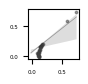

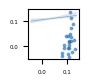

In [18]:
## plot effect size for replication
mod = 4
fig, ax = plt.subplots(figsize=(.65, .65))
dis_425=[]
rep_425=[]
colormaps = ['Greys', 'Blues']
for i in range(58):
    if category.values[i] == 'Trait-like':
        colormap = plt.get_cmap(colormaps[0])
        a = replicability_results[mod][i][1][16]
        b = replicability_results[mod][i][2][16]
        plt.scatter(a,b, s=3, alpha=0.5, color=colormap(0.8))
        plt.xticks(fontsize=4)
        plt.yticks(fontsize=4)

        dis_425.append(replicability_results[mod][i][1][16])
        rep_425.append(replicability_results[mod][i][2][16])
dis_425 = np.array(dis_425)
rep_425 = np.array(rep_425)

sns.regplot(y=dis_425, x=rep_425, 
                    color=colormap(0.9), 
                    scatter=False,
                    line_kws={"linewidth": 0.5, 'alpha': 0.4}
                    )

fig, ax = plt.subplots(figsize=(.65, .65))

dis_425=[]
rep_425=[]
for i in range(58):   
    if category.values[i] == 'State-like':
        colormap = plt.get_cmap(colormaps[1])
        a = replicability_results[mod][i][1][16]
        b = replicability_results[mod][i][2][16]
        plt.scatter(a,b, s=3, alpha=0.5, color=colormap(0.8))
        plt.xticks(fontsize=4)
        plt.yticks(fontsize=4)
        
        
        dis_425.append(replicability_results[mod][i][1][16])
        rep_425.append(replicability_results[mod][i][2][16])
dis_425 = np.array(dis_425)
rep_425 = np.array(rep_425)

sns.regplot(y=dis_425, x=rep_425, 
                    color=colormap(0.9), 
                    scatter=False,
                    line_kws={"linewidth": 0.5, 'alpha': 0.4}
                    
                    )

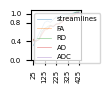

In [19]:
ef_size_df = []
for mod in range(5):
    e_mod = []
    for i in finalInd:
        e = replicability_results[mod][i][1]
        e_mod.append(e)
    e_mod = np.array(e_mod)
    dis = pd.DataFrame(e_mod).mean(axis=0)

    e_mod = []
    for i in finalInd:
        e = replicability_results[mod][i][2]/replicability_results[mod][i][1] 
        e_mod.append(e)
    e_mod = np.array(e_mod)
    rep = pd.DataFrame(e_mod).mean(axis=0)
    
    dis_rep = pd.concat([dis, rep], axis=1)
    dis_rep.columns = ['discovery', 'replication']
    ef_size_df.append(dis_rep)
ef_size_df = pd.concat(ef_size_df, axis=1)
ef_size_df.columns = ['discovery_streamlines', 'replication_streamlines',
                       'discovery_fa', 'replication_fa',
                       'discovery_rd', 'replication_rd',
                       'discovery_ad', 'replication_ad',
                       'discovery_adc', 'replication_adc']

ef_size_df = ef_size_df.round(2)
fig, ax = plt.subplots(figsize=(.65, .65))
plt.plot(ef_size_df.iloc[:,1], alpha=0.5, linewidth=0.5)
plt.plot(ef_size_df.iloc[:,3], alpha=0.5, linewidth=0.5)
plt.plot(ef_size_df.iloc[:,5], alpha=0.5, linewidth=0.5)
plt.plot(ef_size_df.iloc[:,7], alpha=0.5, linewidth=0.5)
plt.plot(ef_size_df.iloc[:,9], alpha=0.5, linewidth=0.5)
ax.set_xticks([0, 4, 8, 12, 16])
ax.set_xticklabels(np.arange(25, 450, 100), rotation=90, fontsize=5)  
ax.set_yticks([0.0, 0.4, 0.8, 1.0])  # 4 ticks
ax.set_yticklabels([0.0, 0.4, 0.8, 1.0], fontsize=5)
ax.legend(['streamlines', 'FA', 'RD', 'AD', 'ADC'], fontsize=5)

In [20]:
ef_size_df.index = np.arange(25, 450, 25) 
ef_size_df

,discovery_streamlines,replication_streamlines,discovery_fa,replication_fa,discovery_rd,replication_rd,discovery_ad,replication_ad,discovery_adc,replication_adc
25,0.46,0.31,0.43,0.42,0.45,0.44,0.45,0.45,0.44,0.41
50,0.36,0.43,0.35,0.41,0.35,0.40,0.35,0.41,0.34,0.41
75,0.31,0.56,0.31,0.43,0.31,0.45,0.32,0.45,0.31,0.43
100,0.29,0.68,0.28,0.54,0.28,0.62,0.27,0.56,0.28,0.58
125,0.27,0.81,0.26,0.64,0.26,0.68,0.26,0.65,0.26,0.68
150,0.26,0.84,0.25,0.66,0.25,0.72,0.26,0.66,0.25,0.69
175,0.26,0.81,0.24,0.74,0.24,0.75,0.24,0.73,0.24,0.74
200,0.25,0.87,0.23,0.73,0.24,0.72,0.23,0.72,0.23,0.71
225,0.25,0.93,0.23,0.77,0.23,0.77,0.23,0.78,0.23,0.77
250,0.24,0.93,0.22,0.76,0.23,0.79,0.22,0.78,0.22,0.78


[]

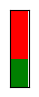

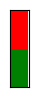

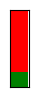

In [21]:
percentage=36;remainder=100-percentage
colors=['green','red']
fig,ax=plt.subplots(figsize=(0.5/2,2/2))
ax.bar(0,percentage,color=colors[0])
ax.bar(0,remainder,bottom=percentage,color=colors[1])
ax.set_ylim(0,100)
ax.set_xticks([])
ax.set_yticks([])

percentage=50;remainder=100-percentage
colors=['green','red']
fig,ax=plt.subplots(figsize=(0.5/2,2/2))
ax.bar(0,percentage,color=colors[0])
ax.bar(0,remainder,bottom=percentage,color=colors[1])
ax.set_ylim(0,100)
ax.set_xticks([])
ax.set_yticks([])

percentage=19;remainder=100-percentage
colors=['green','red']
fig,ax=plt.subplots(figsize=(0.5/2,2/2))
ax.bar(0,percentage,color=colors[0])
ax.bar(0,remainder,bottom=percentage,color=colors[1])
ax.set_ylim(0,100)
ax.set_xticks([])
ax.set_yticks([])




Calculate the results

In [22]:
allCounts.columns = phenotype_names
def smooth_array(array, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be positive.")
    return np.convolve(array, np.ones(window_size) / window_size, mode='same')

(np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(1.0))
(np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(1.0))
(np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(1.0))
(np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(1.0))
(np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(0.11380238369857748), np.float64(1.0))


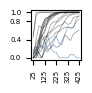

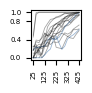

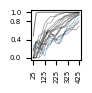

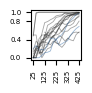

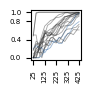

In [23]:
# figure for effect sizes
list = ['SC', 'FA', 'RD', 'AD', 'ADC']
#colormaps = ['Greys', 'Reds', 'Greens', 'Blues', 'cividis']
colormaps = ['Greys', 'Blues']
for enu, method in enumerate(list):
    fig, ax = plt.subplots(figsize=(0.65, 0.65))
    c = 1
    line_width = 0.6
    for i in finalInd:
        if combined.iloc[i]['category']=='Trait-like':
            colormap = plt.get_cmap(colormaps[0])
        else:
            colormap = plt.get_cmap(colormaps[1])
            
        plt.plot(smooth_array(replicability_results[enu][i][0], 2), 
                linewidth=line_width, 
                color=colormap(0.9),
                alpha=0.4)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.set_xticklabels(np.arange(25, 450, 100), rotation=90, fontsize=5)  
    ax.set_yticks([0.0, 0.4, 0.8, 1.0])  # 4 ticks
    ax.set_yticklabels([0.0, 0.4, 0.8, 1.0], fontsize=5)
    print(colormap(0.9))

#### theoretical replicability

PearsonRResult(statistic=np.float64(-0.7474681997492436), pvalue=np.float64(0.0008732039786324173))

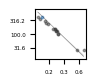

In [24]:
# theretical replicability

def theoretical_replicability(effect_size, sample_size, alpha):
    for i in range(sample_size):
        psrep = r2psrep(effect_size, i, alpha)
        if psrep > 0.8:
            return i

fig, ax = plt.subplots(figsize=(0.65, 0.65))
colormaps = ['Greys', 'Blues']
name = 'streamlines'
sample_name = f'sample_size_{name}'
effect_name = f'effect_size_rep_{name}'

psrep_all = []
empirical_effect = []
samples = []
for i in finalInd:
    if combined.iloc[i]['category']=='Trait-like':
        colormap = plt.get_cmap(colormaps[0])
    else:
        colormap = plt.get_cmap(colormaps[1])
    if combined.iloc[i][sample_name] < 450:
        try:
            psrep = theoretical_replicability(combined.iloc[i][effect_name], 1000, 0.05)
            plt.scatter(y=np.log10(combined.iloc[i][sample_name]), x=np.log10(combined.iloc[i][effect_name]), 
                                s=3, alpha=0.5, color=colormap(0.8))
            plt.xticks(fontsize=4)
            plt.yticks(fontsize=4)
            
            psrep_all.append(psrep)
            empirical_effect.append(combined.iloc[i][effect_name])
            samples.append(combined.iloc[i][sample_name])
            
        except TypeError:
            continue

empirical_effect = np.array(empirical_effect)
psrep_all = np.array(psrep_all)
samples = np.array(samples)
sns.regplot(y=np.log10(psrep_all), x=np.log10(empirical_effect), 
                    color=colormap(0.9), 
                    scatter=False,
                    line_kws={"linewidth": 0.5, 'alpha': 0.4}
                    )
import matplotlib.ticker as ticker 
def format_tick_label_actual_value(value, pos):
    return f"{np.round(10**value,1)}"

actual_value_formatter = ticker.FuncFormatter(format_tick_label_actual_value)

ax.xaxis.set_major_formatter(actual_value_formatter)
ax.yaxis.set_major_formatter(actual_value_formatter)

ax.tick_params(axis='both', which='major', labelsize=4)
    
pearsonr(empirical_effect, psrep_all)
pearsonr(psrep_all, samples)
pearsonr(empirical_effect, samples)

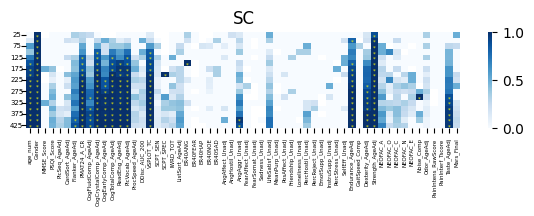

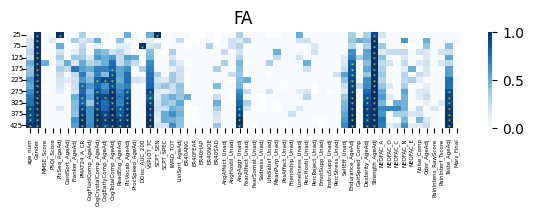

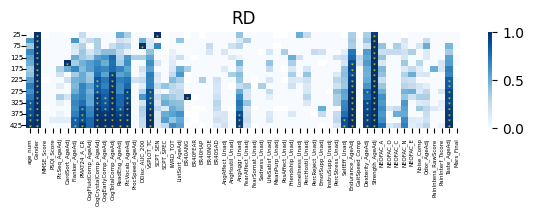

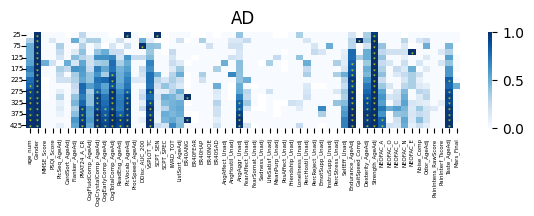

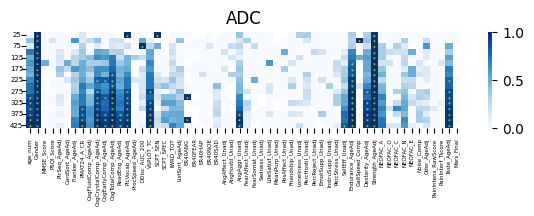

In [25]:
for enu, i in enumerate(list):
    fig, ax = plt.subplots(figsize=(7,1.25), dpi=100)
    sns.heatmap(np.stack(np.array(allCounts.iloc[enu,:])).T, cmap='Blues', cbar=True)
    # keep an astrick for the values greater than or equal to 0.8
    for j in range(58):
        for k in range(17):
            if allCounts.iloc[enu,j][k] >= 0.8:
                ax.text(j+0.5,k+0.75, '*', color='yellow', ha='center', va='center', fontsize=4)
    
    ax.set_yticks(np.arange(0.5, 17.5, 2)) # ticks should be in the center of the box
    ax.set_yticklabels(np.arange(25, 450, 50), rotation=0, fontsize=5, ha='center')  
    ax.set_xticks(np.arange(0.5, 58.5, 1)) # ticks should be in the center of the box
    ax.set_xticklabels(phenotype_names, rotation=90, fontsize=4) 
    ax.set_title(i)